# How colors are mentioned and how they are related to objects in letters

In [1]:
import pandas as pd # library for data analysis
import re
import shutil
import webcolors
import spacy
from spacy import displacy
from collections import Counter
from spacy.matcher import Matcher
from spacy.util import filter_spans 
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
import seaborn as sns

nlp = spacy.load('en_core_web_sm')

In [2]:
letters = pd.read_csv("letter_raw.csv")
len(letters)

902

In [3]:
# get year
year = []
# get month
month = []
for i, row in letters.iterrows():
    if(not row['date'].endswith('.')):
        #print(row['id'])
        row['date'] = row['date']+'.'
    if(not row['date'][:-1][-1].isdigit()):
        #print(row['id'])
        letters.drop(i, inplace=True)
        continue
    year.append(row['date'][:-1][-4:])
    month.append(row['date'].split(" ")[-2].split("-")[-1])
letters['year'] = year
letters['month'] = month

In [4]:
letters_from_VG = letters.loc[(letters["from"] == "Vincent van Gogh")] # only letters from VG
letters_from_VG = letters_from_VG[(letters_from_VG["year"] >= "1880")] # only letters after VG started to paint

In [5]:
yearlynum = dict(letters_from_VG.groupby(['year']).size())

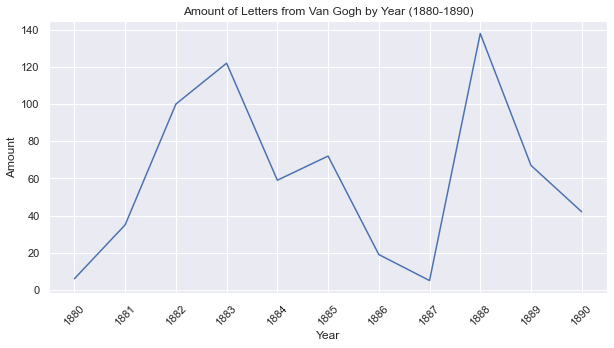

In [6]:
ylist = yearlynum.items()
x, y = zip(*ylist)

sns.set(rc={'figure.figsize':(10,5)})
plt.plot(x, y)
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Amount')
plt.title('Amount of Letters from Van Gogh by Year (1880-1890)')
plt.show()

### Construct color list

In [7]:
webcolors.css3_names_to_hex.keys()

dict_keys(['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'grey', 'green', 'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgrey', 'lightgreen', 'lightpink', 'lightsalmon', 'lights

In [8]:
# construct the list manually from the webcolors and search function on the letter website
# not include words like dark/light/pale, as they are description of color #sepia, cobalt
color_words = ['colour', 'tint', 'purplish', 'yellowish', 'azure', 'black',
              'blue', 'brown', 'crimson', 'gold', 'silver', 'ivory', 'indigo', 'green',
              'grey', 'orange', 'pink', 'purple', 'red', 'violet', 'white', 'yellow',
              'ochre', 'sienna', 'carmine', 'vermilion', 'ultramarine', 'gamboge', 'reddish', 'brownish',
              'greenish', 'greyish', 'golden'] 

### Get sentences contain keywords

In [19]:
'''
for each letter, loop over the content sentence by sentence, 
get sentences contain key words
'''
sents_w_keyword = {} #{"year":[(id, month, sent)]}
sc = [] # sentence count
for i, row in letters_from_VG.iterrows():
    year = row['year']
    month = row['month']
    to = row['to']
    doc = nlp(row.content)
    sentence_count = 0
    #for token in doc:
     #   if(token.pos_ != "PUNCT" and token.pos_ != "SYM" and token.pos_ != "SPACE"):
      #      word_count += 1
    #wc.append(word_count)
    #sentence_count = len(doc.sents)
    #sc.append(sentence_count)
    for sentence in doc.sents:
        sentence_count += 1
        sentence = sentence.text
        
        for word in color_words:
            if word in sentence.lower().split():
                if year in sents_w_keyword:
                    sents_w_keyword[year].append((row.id, month, sentence, to))
                else:
                    sents_w_keyword[year] = [(row.id, month, sentence, to)]
                break # find one keyword in sentence is enough
    sc.append(sentence_count)
                
letters_from_VG['sentence_count'] = sc

In [12]:
yearlysc = dict(letters_from_VG.groupby('year')['sentence_count'].sum())

In [13]:
years = range(1880, 1891)
freq_by_year = {}
for year in years:
    if str(year) in sents_w_keyword.keys():
        freq_by_year[str(year)] = len(sents_w_keyword[str(year)])/yearlysc[str(year)] #/yearlynum[str(year)]
    else:
        freq_by_year[str(year)] = 0

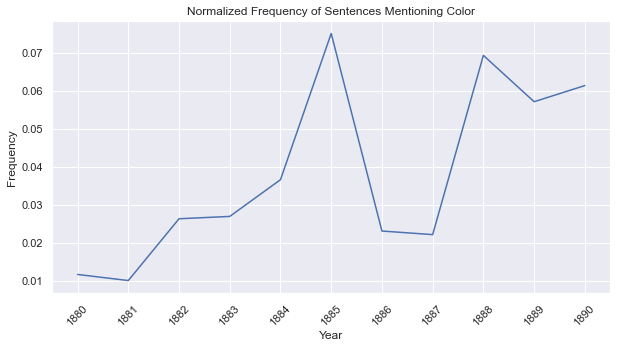

In [14]:
ylist = freq_by_year.items()
x, y = zip(*ylist)

sns.set(rc={'figure.figsize':(10,5)})
plt.plot(x, y)
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Normalized Frequency of Sentences Mentioning Color')
plt.show()

### How color is described & the object associated with it

In [15]:
filtered_word_list = {"latter", "narrow", "huge", "few", "different", "same", "like", "big",
                      "long", "young", "great", "tall", "first", "threadbare", "new", "individual", 
                      "old", "little", "large", "many", "much", "small", "more", "certain", "only",
                     "other", "enough", "high", "local", "low", "actual", "own", "rounded",
                     "moist", "several", "wet", "aforementioned", "horizontal", "enormous", "damp",
                     "single", "distant", "exquisite", "coarse", "poor", "vast", "wild", "liquid",
                     "vague", "bushy", "possible", "away", "even", "always", "usually", "also", "as",
                     "more", "less", "all"}

In [16]:
def takeStart(ne):
    return ne[0]
    
# noun phrase: (DET)?(ADJ)*(NOUN)*Noun
#[{"POS":"DET","OP":"?"}, {"POS":"ADJ","OP":"*"}, {"POS":"NOUN","OP":"+"}]  
matcher = Matcher(nlp.vocab)
matcher.add("NP", [[{"POS":"DET","OP":"?"}, {"POS":"ADJ","OP":"*"}, {"POS":"NOUN","OP":"+"}]])

# take the adjectives before the color word
expanded_color_words = {}
for year in sents_w_keyword.keys():
    expanded_color_words[year] = []
    # for each sentence
    for comp in sents_w_keyword[year]:
        #### first, match the pattern of noun phrase
        letter_id = comp[0]
        letter_month = comp[1]
        doc = nlp(comp[2])
        matches = matcher(doc)
        spans = [doc[start:end] for _, start, end in matches]
        filtered = filter_spans(spans)   

        savedNP = [] #[(start, end, NP)]
        for _, start, end in matches:
            if(doc[start:end] in filtered):
                savedNP.append((start, end, doc[start:end]))

        savedNP.sort(key=takeStart)  


        i = 0
        for j in range(len(doc)):
            if doc[j].text.lower() in color_words:
                # find the adj that before this color word 
                color_phrase = doc[j].text.lower()
                # light blue/ sickly green/ (lemon yellow)
                if(j-1>=0 and (doc[j-1].pos_=="ADJ" or doc[j-1].pos_=="ADV") and doc[j-1].text.lower() not in color_words and doc[j-1].text.lower() not in filtered_word_list):
                    color_phrase = doc[j-1].text.lower() + " " + doc[j].text.lower()
                
                np_before_dist = 0 # distance to the end of the NP before color word
                np_after_dist = 0 # distance to the start of the NP after color word

                closestNP = None
                beforeNP = None
                afterNP = None
                for np in savedNP:
                    # dont consider if the other color words are recognized as noun
                    if(np[2].text.split(" ")[-1] in color_words):
                        continue
                    # need to consider the situation when the color word is part of the NP! Then it must be an adjective!
                    if(np[0]<=i and np[1]>i and doc[j].pos_=="ADJ"):
                        closestNP = np[2] # find the NP! break!
                        break

                    before_dist = i-np[1] # distance of color word and the NP before it
                    after_dist = i-np[0] # distance of color word and the NP after it
                    if(before_dist>=0):
                        np_before_dist = before_dist
                        beforeNP = np[2]
                    if(after_dist<0):
                        np_after_dist = after_dist 
                        afterNP = np[2]
                        break # find closest NP after the color word, for loop can be ended

                if(closestNP == None):
                    # compare the distance of NP from before and after the color word
                    if(abs(np_before_dist)>abs(np_after_dist)):
                        closestNP = afterNP
                    else:
                        closestNP = beforeNP

                expanded_color_words[year].append((letter_id, letter_month, color_phrase, closestNP)) 
            i += 1
    

In [17]:
colors_mentioned_by_year = {} #{year: #words}
for year in range(1880, 1891):
    if(str(year) not in expanded_color_words.keys()):
        colors_mentioned_by_year[str(year)] = []
        continue
    colors_mentioned_by_year[str(year)] = set([color for lid, lm, color, obj in expanded_color_words[str(year)]])

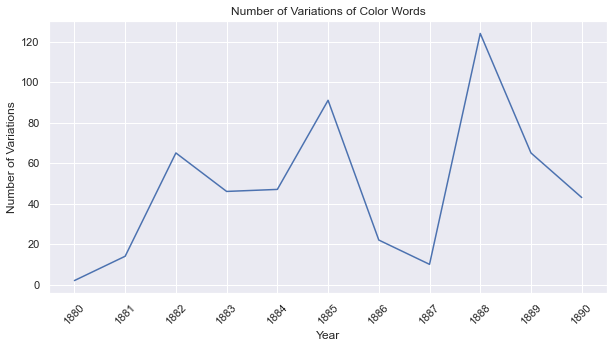

In [18]:
no_colors_mentioned_by_year = {}

for year in colors_mentioned_by_year:
    no_colors_mentioned_by_year[year] = len(colors_mentioned_by_year[year])
    
ylist = no_colors_mentioned_by_year.items()
x, y = zip(*ylist)

sns.set(rc={'figure.figsize':(10,5)})
plt.plot(x, y)
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Number of Variations')
plt.title('Number of Variations of Color Words')
plt.show()

### Talk color to whom 

In [20]:
ids_color = []
for year in sents_w_keyword:
    for comp in sents_w_keyword[year]:
        ids_color.append(comp[0])
        
ids_color = set(ids_color)

In [21]:
len(ids_color) 

407

In [22]:
len(letters_from_VG) # 407 letters talk about color out of 665 letters

665

In [24]:
to_whom = {}
for i, row in letters_from_VG.iterrows():
    if row.id in ids_color:
        if row.to in to_whom:
            to_whom[row.to] += 1
        else:
            to_whom[row.to] = 1

In [27]:
to_whom # 318 letters sent to Theo VG out of the 407 letters

{'Theo van Gogh': 304,
 'Theodorus van Gogh and Anna van Gogh-Carbentus': 2,
 'Anthon van Rappard': 30,
 'Theo van Gogh, The Hague, on or about Thursday, 6 April 1882.': 1,
 'Theo van Gogh, The Hague, on or about Saturday, 7 July 1883.': 1,
 'Theo van Gogh, The Hague, on or about Wednesday, 11 July 1883.': 1,
 'Theo van Gogh, The Hague, Sunday, 22 July 1883.': 1,
 'Theo van Gogh, The Hague, on or about Wednesday, 25 July 1883.': 1,
 'Theo van Gogh, The Hague, on or about Friday, 27 July 1883.': 1,
 'Theo van Gogh, The Hague, Sunday, 29 and Monday, 30 July 1883.': 1,
 'Antoine Philippe Furnée': 1,
 'Anton Kerssemakers': 1,
 'Cornelis Marinus van Gogh': 1,
 'Theo van Gogh, Antwerp, Monday, 14 December 1885.': 1,
 'Theo van Gogh, Antwerp, on or about Thursday, 28 January 1886.': 1,
 'Horace Mann Livens, Paris, September or October 1886.': 1,
 'Willemien van Gogh': 19,
 'Emile Bernard': 16,
 'John Peter Russell': 2,
 'Arnold Koning': 2,
 'Eugène Boch': 1,
 'Paul Gauguin': 4,
 'Paul Signac'

### Blue & Green & Yellow 

In [28]:
blue_by_years = {}
green_by_years = {}
yellow_by_years = {}

for year in expanded_color_words:
    blue_by_years[year] = []
    green_by_years[year] = []
    yellow_by_years[year] = []
    for comp in expanded_color_words[year]:
        if "blue" in comp[2]:
            blue_by_years[year].append(comp[2])
        elif "green" in comp[2]:
            green_by_years[year].append(comp[2])
        elif "yellow" in comp[2]:
            yellow_by_years[year].append(comp[2])
    blue_by_years[year] = set(blue_by_years[year])
    green_by_years[year] = set(green_by_years[year])
    yellow_by_years[year] = set(yellow_by_years[year])

In [ ]:
no_blue_by_years = {}
for year in blue_by_years:
    no_blue_by_years[year] = len(blue_by_years[year])
    
no_green_by_years = {}
for year in green_by_years:
    no_green_by_years[year] = len(green_by_years[year])
    
no_yellow_by_years = {}
for year in yellow_by_years:
    no_yellow_by_years[year] = len(yellow_by_years[year])

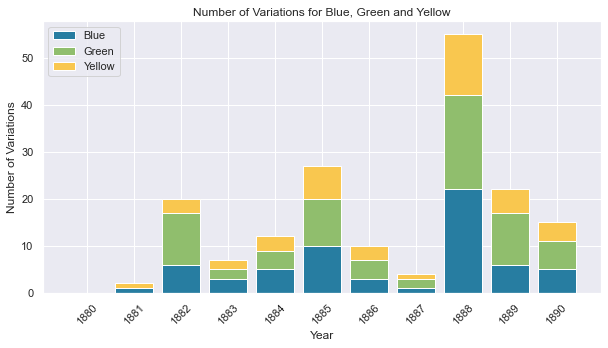

In [53]:
ylist_blue = no_blue_by_years.items()
x_blue, y_blue = zip(*ylist_blue)

ylist_green = no_green_by_years.items()
x_green, y_green = zip(*ylist_green)

ylist_yellow = no_yellow_by_years.items()
x_yellow, y_yellow = zip(*ylist_yellow)

import numpy as np
y_blue = np.array(y_blue)
y_green = np.array(y_green)
sum_bg = y_blue+y_green

sns.set(rc={'figure.figsize':(10,5)})
plt.bar(x_blue, y_blue, color='#277da1', label="Blue")
plt.bar(x_blue, y_green, bottom=y_blue, color='#90be6d', label="Green")
plt.bar(x_blue, y_yellow, bottom=sum_bg, color='#f9c74f', label="Yellow")
plt.legend(loc="upper left")
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Number of Variations')
plt.title('Number of Variations for Blue, Green and Yellow')
plt.show()

### Monthly change from 1885 to 1890 (NOT DESIRED RESULT)

In [25]:
colors_mentioned_by_month = {} #{year-month: #words}
for year in range(1885, 1891):
    for m in ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]:
        key = str(year)+"-"+m
        colors_mentioned_by_month[key] = []
        
for year in range(1885, 1891):
    for lid, lm, color, obj in expanded_color_words[str(year)]:
        key = str(year)+"-"+str(lm)
        colors_mentioned_by_month[key].append(color)
        

In [26]:
for key in colors_mentioned_by_month:
    colors_mentioned_by_month[key] = set(colors_mentioned_by_month[key])

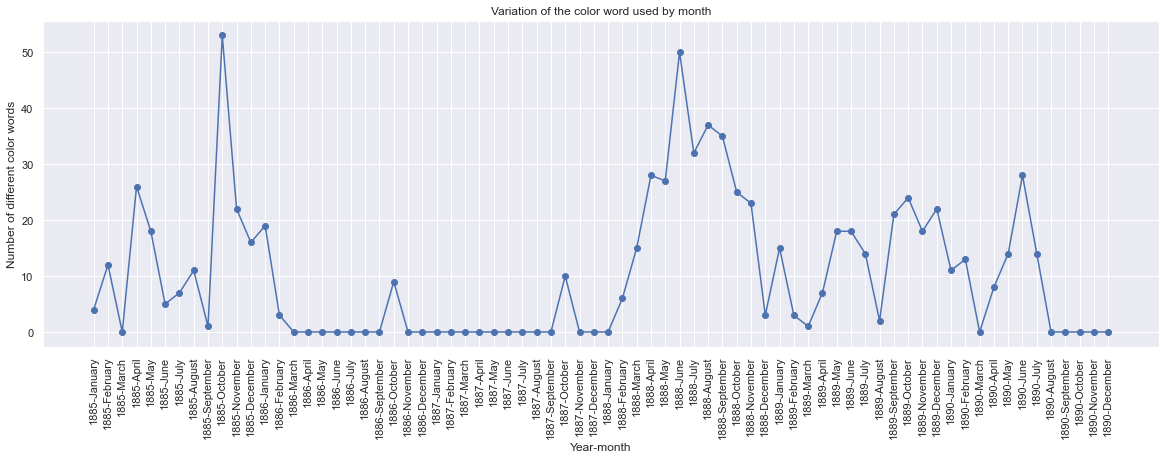

In [47]:
no_colors_mentioned_by_m = {}

for key in colors_mentioned_by_month:
    no_colors_mentioned_by_m[key] = len(colors_mentioned_by_month[key])
    
ylist = no_colors_mentioned_by_m.items()
x, y = zip(*ylist)


sns.set(rc={'figure.figsize':(20,6)})
plt.plot(x, y, marker='o')
plt.xlabel('Year-month')
plt.xticks(rotation=90)
plt.ylabel('Number of different color words')
plt.title('Variation of the color word used by month')
plt.show()

### Object with color 

In [28]:
def takeObj(elem):
    return (elem[0], elem[1])

obj_color = []
for key in expanded_color_words:
    for item in expanded_color_words[key]:
        if(item[3] == None):
            continue
        obj_color.append((str(item[3]).split(" ")[-1], key, item[2], item[0]))
obj_color.sort(key=takeObj)

In [29]:
len(obj_color) # see how VG's color of the same object change or not

2484

### Mentions of Gauguin

In [30]:
vg_mention_gg = letters.loc[(letters["from"] == "Vincent van Gogh")]
for i, row in vg_mention_gg.iterrows():
    if("Gauguin" not in row.content):
        vg_mention_gg.drop(i, inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
subset = [] # letter that talks about color
for y in ["1888", "1889", "1890"]:
    for item in expanded_color_words[y]:
        subset.append(item[0])
subset = set(subset)

In [33]:
for i, row in vg_mention_gg.iterrows():
    if(row.id not in subset):
        vg_mention_gg.drop(i, inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [35]:
vg_mention_gg_ids = [] # get the letter ids where VG talked about GG => close reading
for i, row in vg_mention_gg.iterrows():
    vg_mention_gg_ids.append(row.id)